# Выбор локации для скважины

Компании «ГлавРосГосНефть» нужно помочь с решением, где бурить новую скважину. В избранном регионе собирают информацию о качестве нефти и объёме её запасов для каждой скважины. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.


### Описание данных

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек
- `product` — объём запасов в скважине (тыс. баррелей).

Каждый файл соответствует своему региону.

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

from scipy.signal import argrelextrema
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Информация о таблице, наличие пропусков 
def get_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    df.info()
    display((df.isna().mean() * 100).sort_values(ascending=False).to_frame(name='пропуски_в_%'))
    return df

In [3]:
# Проверка наличия директории 
def check_dataset(path0, path1, sep):
    if os.path.exists(path0):
        return get_dataset(path0, sep)
    elif os.path.exists(path1):
        return get_dataset(path0, sep)
    else:
        print('неправильный путь к файлу')

In [4]:
path0 = './datasets/geo_data_0.csv'
path1 = '/datasets/geo_data_0.csv'

geo_data_0 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


Датасет состоит из 100.000 наблюдений. Пропуски и неправильные типы данных отсутствуют.

In [5]:
path0 = './datasets/geo_data_1.csv'
path1 = '/datasets/geo_data_1.csv'

geo_data_1 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


In [6]:
path0 = './datasets/geo_data_2.csv'
path1 = '/datasets/geo_data_2.csv'

geo_data_2 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


#### Вывод загрузки данных

Все датасеты не имеют пропусков, неправильных типов данных.

### Предобработка данных

In [7]:
print('Количество неявных дубликатов')
print('geo_data_0:', geo_data_0.duplicated(subset=['f0', 'f1', 'f2']).sum())
print('geo_data_1:', geo_data_1.duplicated(subset=['f0', 'f1', 'f2']).sum())
print('geo_data_2:', geo_data_2.duplicated(subset=['f0', 'f1', 'f2']).sum())

Количество неявных дубликатов
geo_data_0: 0
geo_data_1: 0
geo_data_2: 0


#### Вывод предобработки данных

Датасеты были проверены на дубликаты по входным признакам. В случае дубликатов, линейная модель может переобучиться на повторяющихся данных и иметь неверные коэффициенты.

### Исследовательский анализ

#### Распределение признаков

In [8]:
def plt_distribution(df):
    plt.figure(figsize=(22, 10))
    cols = df.select_dtypes(include='number').columns
    df = df[cols].copy()

    for i, clm in enumerate(cols):
        plt.subplot(2, 2, i+1)
        if df[clm].nunique() >= 20:
            ax = sns.histplot(data=df, x=clm, stat="density")
            sns.kdeplot(data=df, x=clm, bw_method=0.07, color="red")
        else:
            df[f'rounded_{clm}'] = round(df[clm], 2)
            ax = sns.countplot(data=df, x=f'rounded_{clm}', color='#1F77B4') 
        ax.set_ylabel('количество')

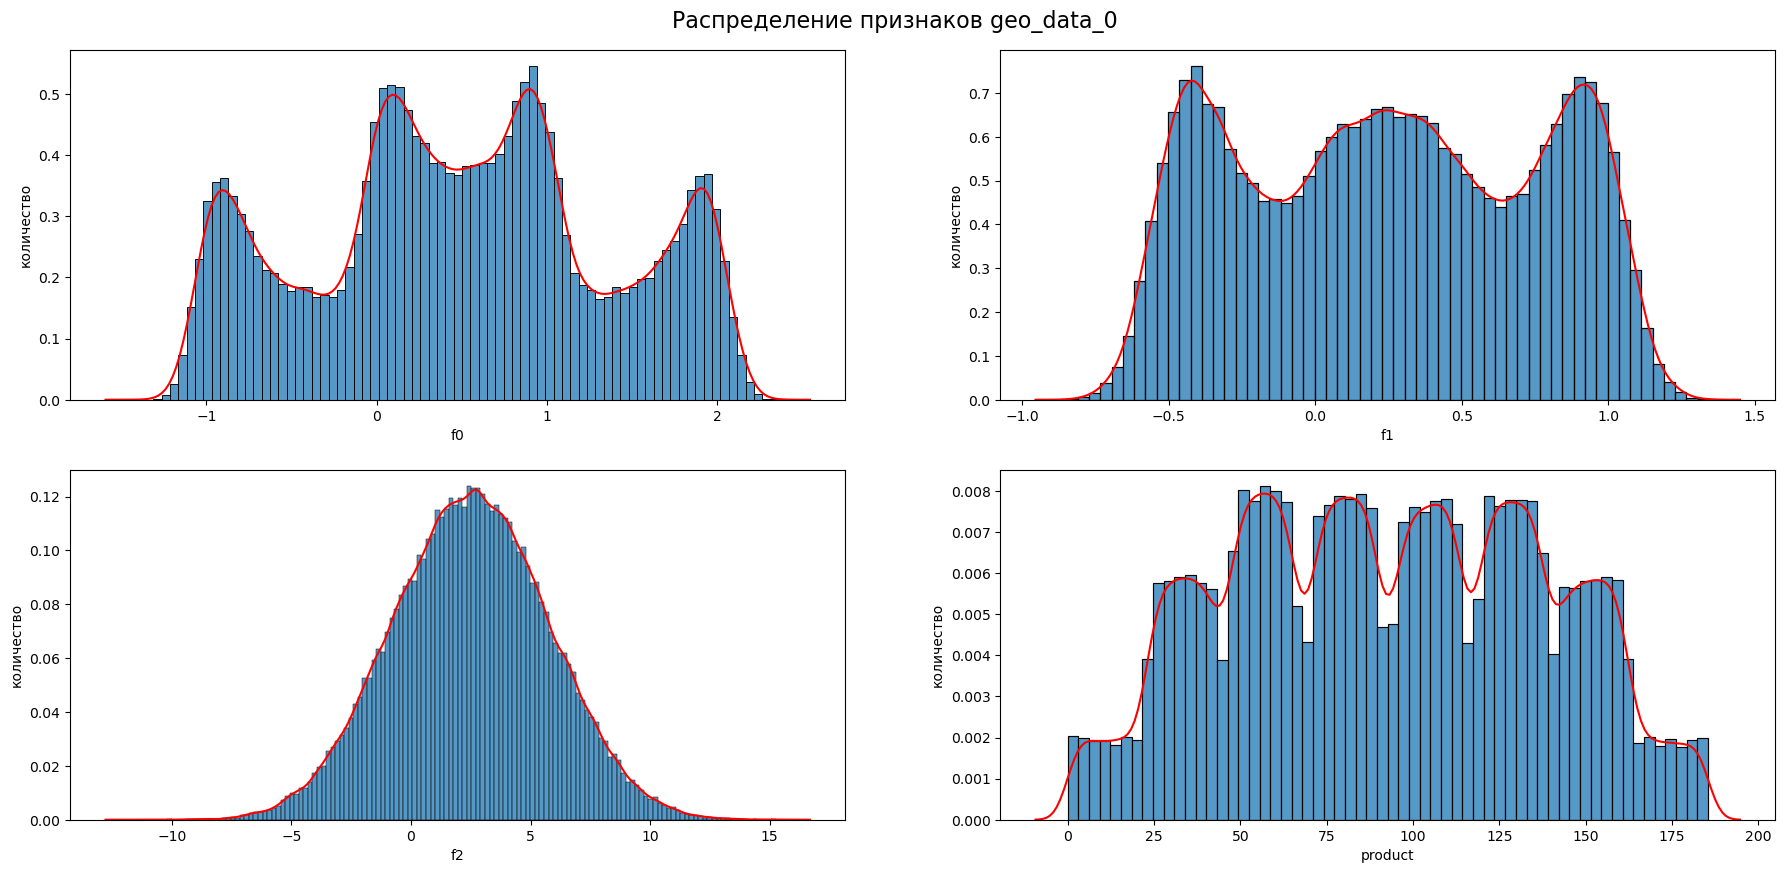

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
plt_distribution(geo_data_0)
plt.suptitle('Распределение признаков geo_data_0', fontsize=16, y=0.92)
plt.show()

geo_data_0.describe()

По распределениям признаков видно, что данные сильно синтетические. Каждый из признаков имеент уникальное распределение:
1. `f0`: мультимодальное распределение с 4-мя вершинами
2. `f1`: мультимодальное распределение с 3-мя вершинами
3. `f2`: нормальное распределение
4. `product`: необычное распределение с множеством равномерных впадин и пиков

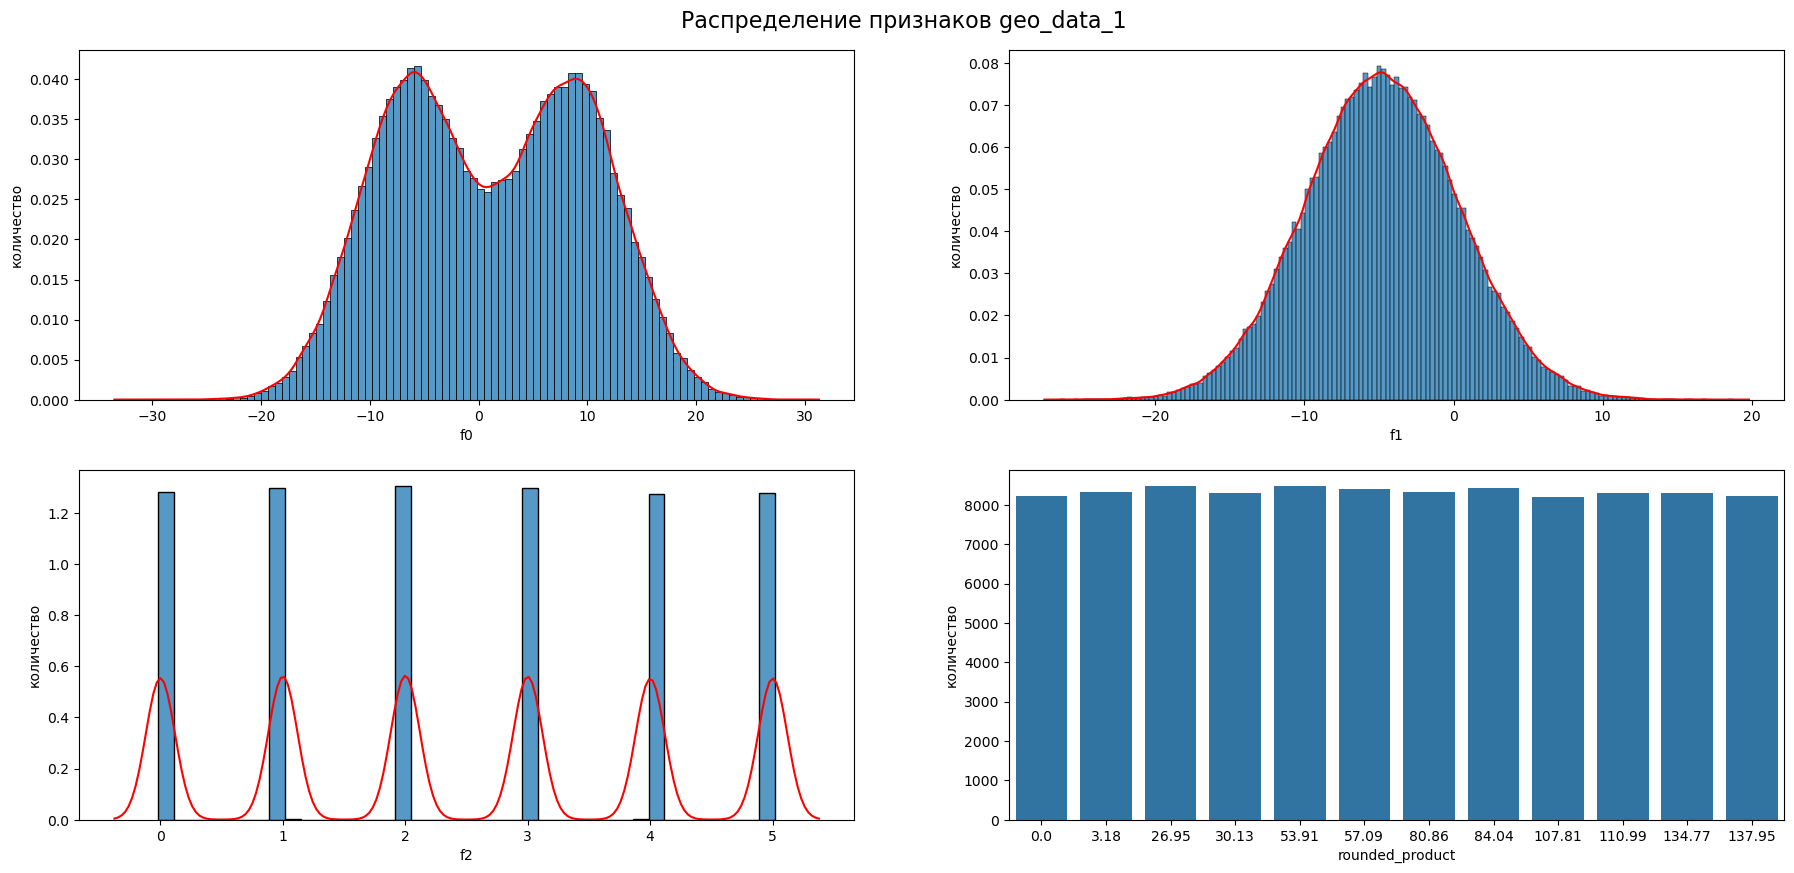

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
plt_distribution(geo_data_1)
plt.suptitle('Распределение признаков geo_data_1', fontsize=16, y=0.92)
plt.show()

geo_data_1.describe()

1. `f0`: бимодальное распределением
2. `f1`: нормальное распределение
3. `f2`: шумный признак, значения кучкуются у целых в равных пропорциях. 
4. `product`: 12 уникальных значений, распределенных равномерно.

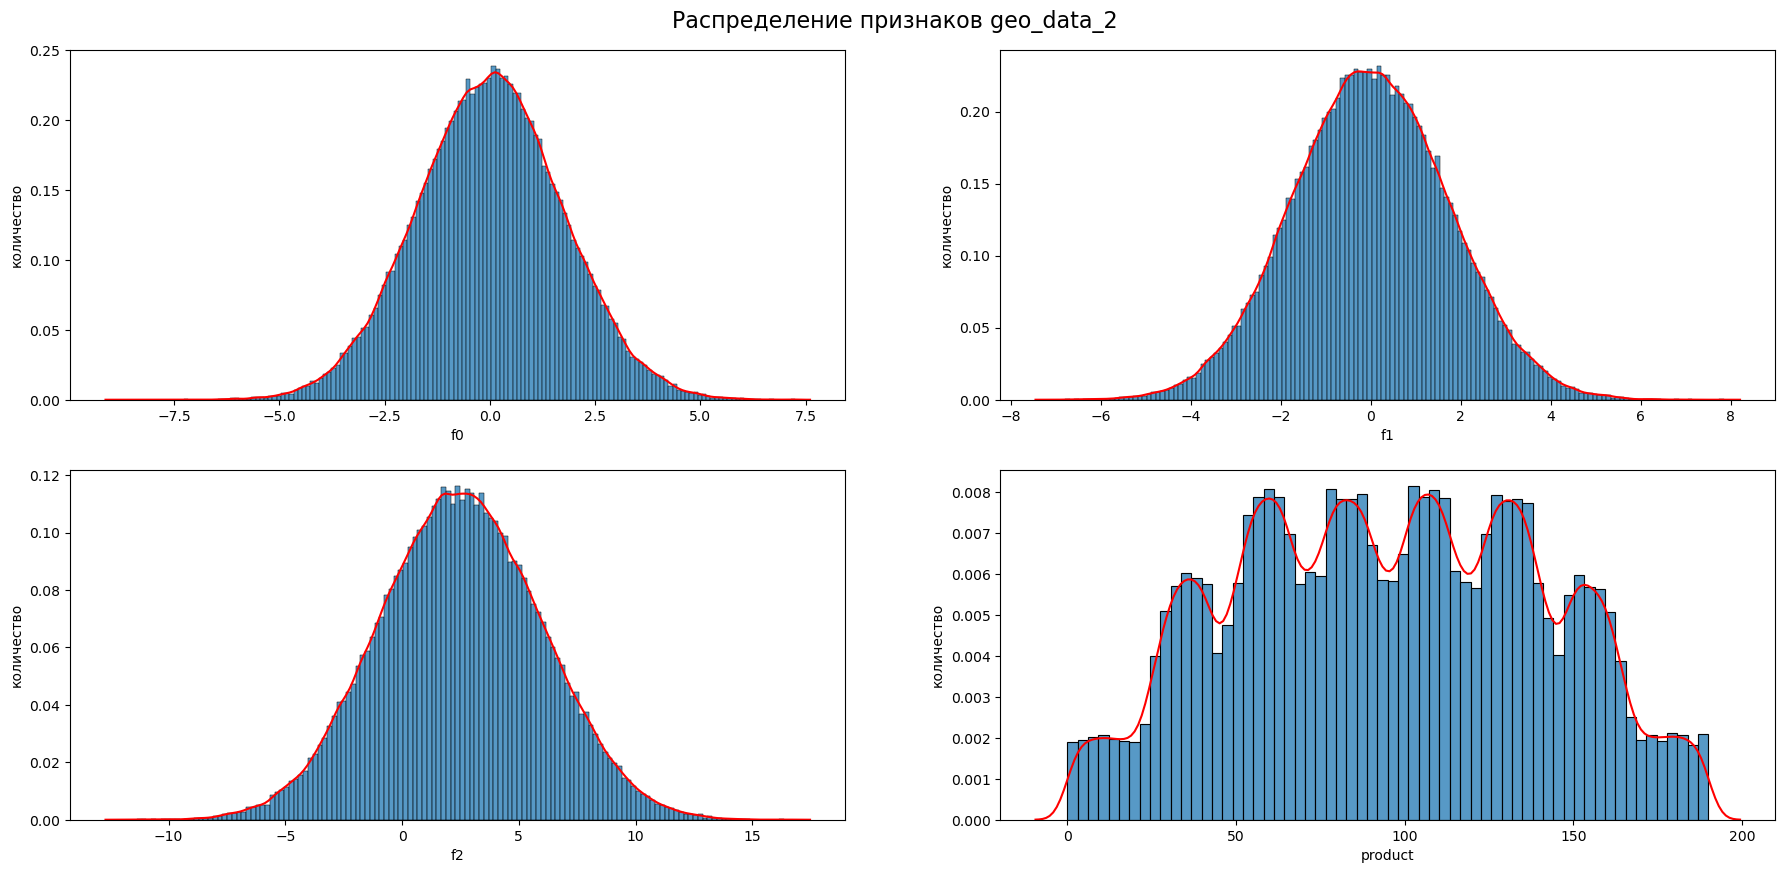

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
plt_distribution(geo_data_2)
plt.suptitle('Распределение признаков geo_data_2', fontsize=16, y=0.92)
plt.show()

geo_data_2.describe()

1. `f0`: нормальное распределение
2. `f1`: нормальное распределение
3. `f2`: нормальное распределение
4. `product`: схоже с распределением из geo_data_0

**Промежуточный вывод:**

В каждом из датасетов данные являются синтетическими. \
В регионе **`geo_data_1`** количество запасов в скважине имеет равномерное распределение, признак состоит из 12 уникальных категорий и наибольшее значение - 138 тыс. баррелей, что меньше по сравнению с двумя другими регионами. В данном регионе признак точек `f2` можно округлить и перевести в категориальный. 

#### Выбросы и аномалии

In [12]:
# Функция для отрисовки диаграммы размаха количественных признаков
def plt_boxplot_scaler(df):
    plt.figure(figsize=(12, 6))
    scaled = MinMaxScaler()
    
    num_columns = [clm for clm in df.select_dtypes(include='number').columns.tolist() if df[clm].nunique() >= 20]
    sns.boxplot(data=pd.DataFrame(data=scaled.fit_transform(df[num_columns]), columns=num_columns), orient='v')


In [13]:
# Функция для избавления от выбросов в количественных признаках
def get_emission_free(df):
    cols = [clm for clm in df.select_dtypes(include='number').columns.tolist() if df[clm].nunique() >= 20]
    for clm in cols:
        IQR = df[clm].quantile(0.75) - df[clm].quantile(0.25)
        minimum = df[clm].quantile(0.25) - 1.5 * IQR
        maximum = df[clm].quantile(0.75) + 1.5 * IQR
        df.query(f'({clm} >= @minimum) and ({clm} <= @maximum)', inplace=True)
        df.reset_index(drop=True, inplace=True)
    plt_boxplot_scaler(df)

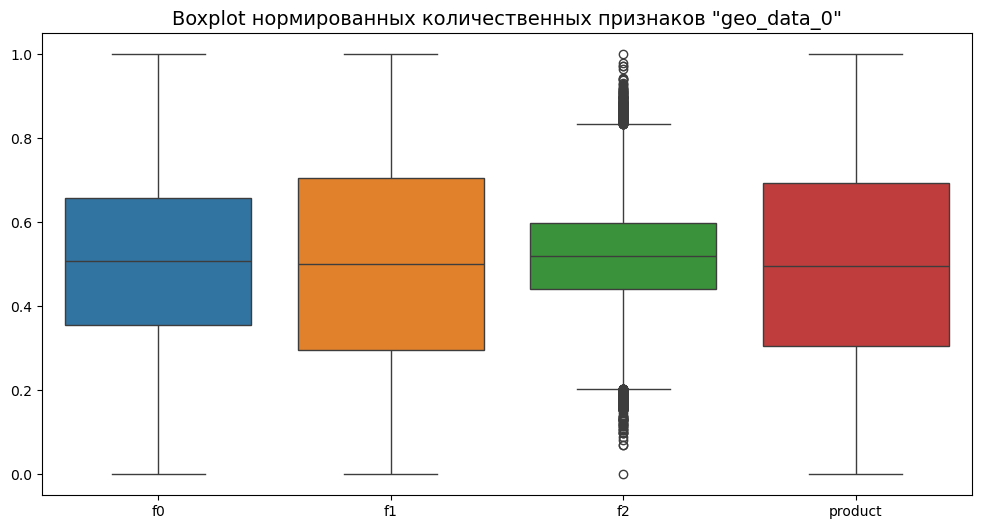

In [14]:
plt_boxplot_scaler(geo_data_0)
plt.title('Boxplot нормированных количественных признаков "geo_data_0"', fontsize=14)
plt.show()

Наблюдаются выбросы у признака `f2`, в данной задаче есть необходимость в удалении таких значений.

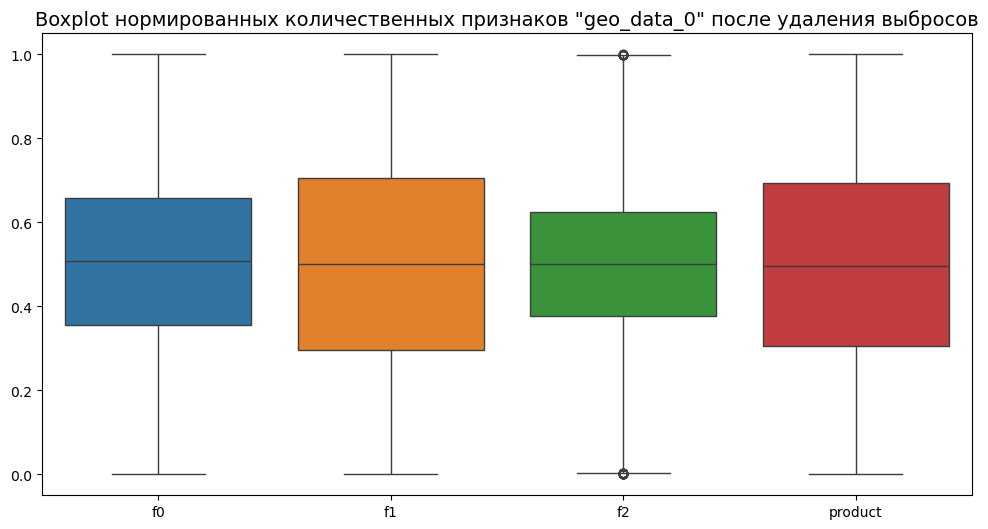

In [15]:
get_emission_free(geo_data_0)
plt.title('Boxplot нормированных количественных признаков "geo_data_0" после удаления выбросов', fontsize=14)
plt.show()

Выбросы признака `f2` в датасете **`geo_data_0`** были удалены.

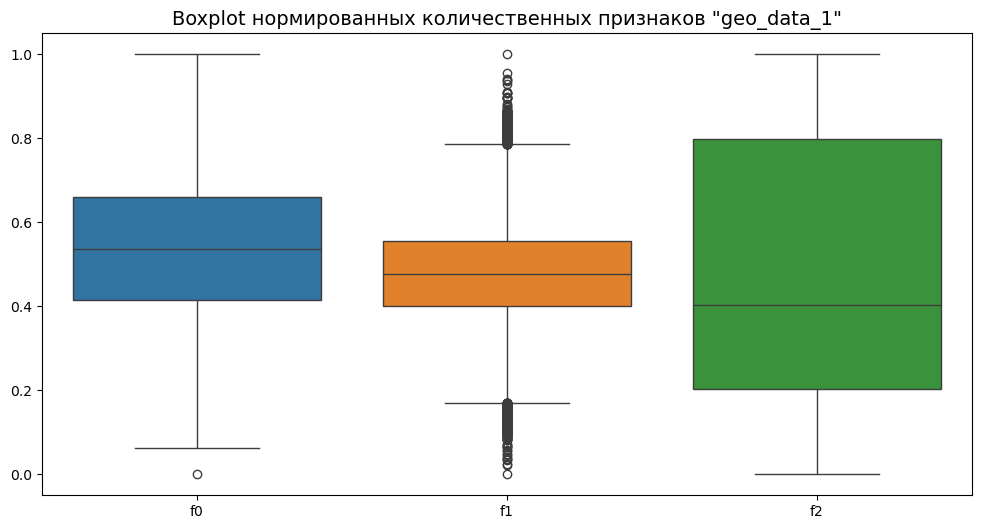

In [16]:
plt_boxplot_scaler(geo_data_1)
plt.title('Boxplot нормированных количественных признаков "geo_data_1"', fontsize=14)
plt.show()

Наблюдаются выбросы у признака `f1` и выброс у `f0`.

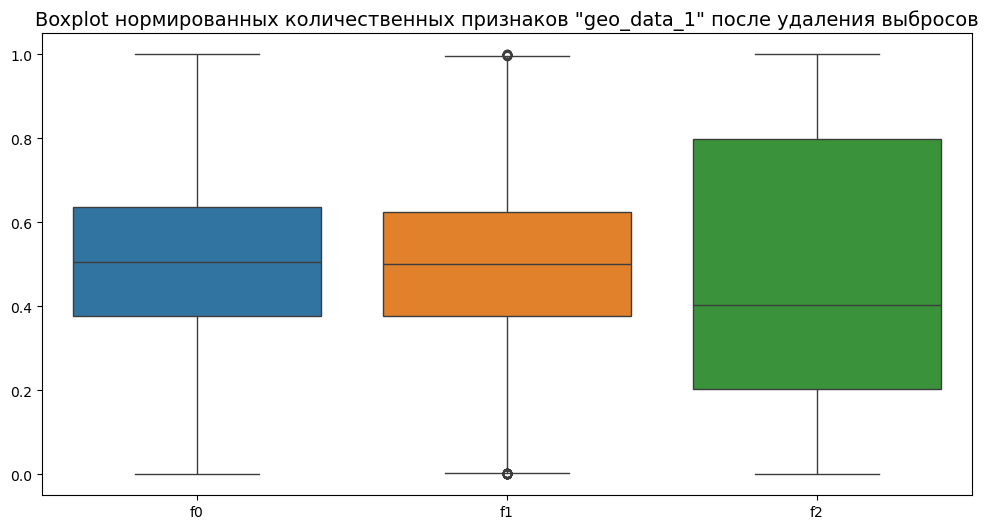

In [17]:
get_emission_free(geo_data_1)
plt.title('Boxplot нормированных количественных признаков "geo_data_1" после удаления выбросов', fontsize=14)
plt.show()

Наблюдения с выбросами признаков `f1` и `f2` были удалены из датасета **`geo_data_1`**.

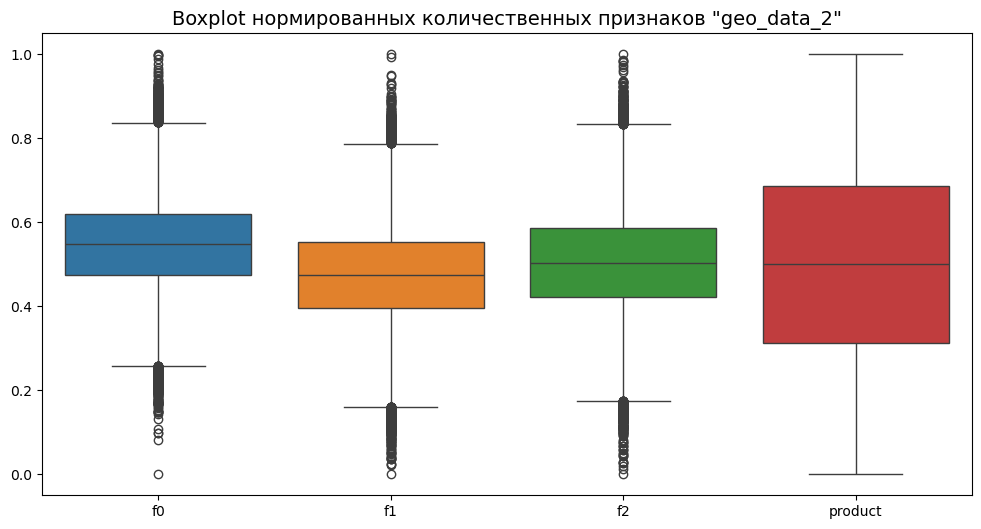

In [18]:
plt_boxplot_scaler(geo_data_2)
plt.title('Boxplot нормированных количественных признаков "geo_data_2"', fontsize=14)
plt.show()

Наблюдаются выбросы у всех входных признаков: `f0`, `f1`, `f2`.

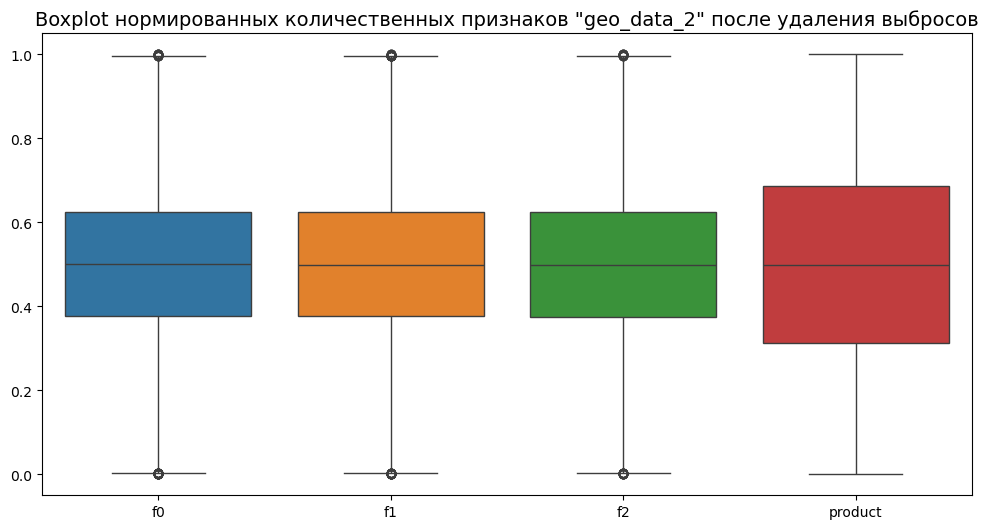

In [19]:
get_emission_free(geo_data_2)
plt.title('Boxplot нормированных количественных признаков "geo_data_2" после удаления выбросов', fontsize=14)
plt.show()

Выбросы в датасете **`geo_data_2`** были удалены.

**Промежуточный вывод:**

В каждом из датасетов имеются выбросы у признаков, которые распределены по Гауссу или бимодально. Все выбросы были убраны фильтром, используя 1.5 межквартильного размаха. Такие значения могли появиться при синтетическом создании данных по функции.

#### Что влияет на большой и малый объём запасов в скважине?

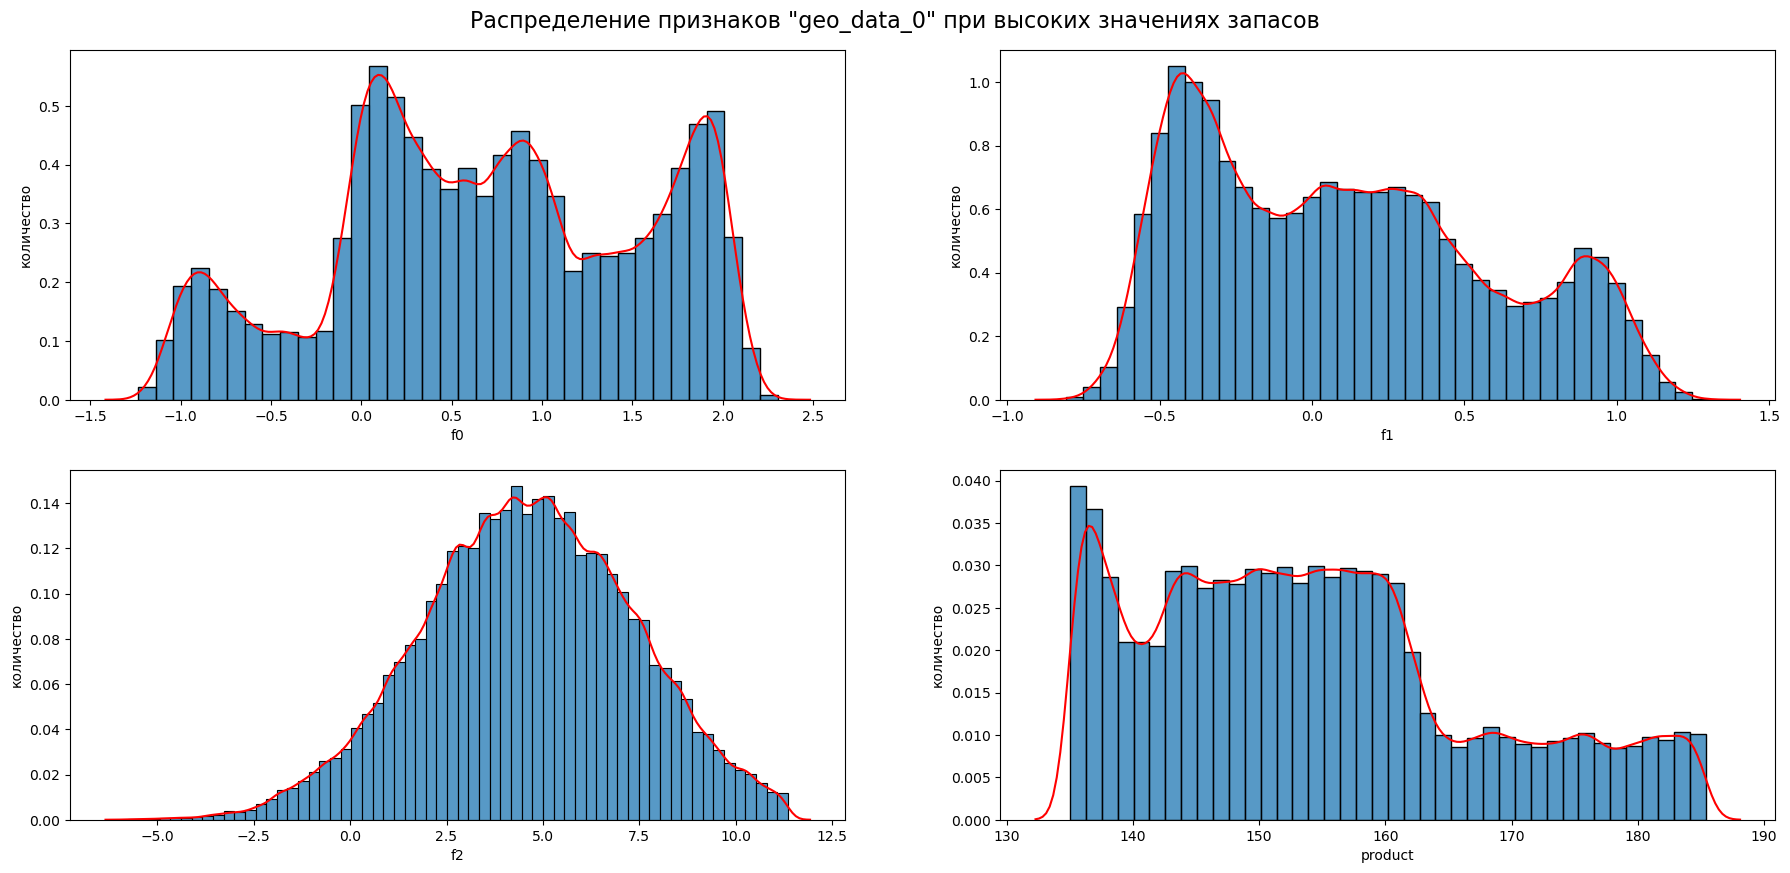

In [20]:
plt_distribution(geo_data_0.query(f'product >= {geo_data_0["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_0" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

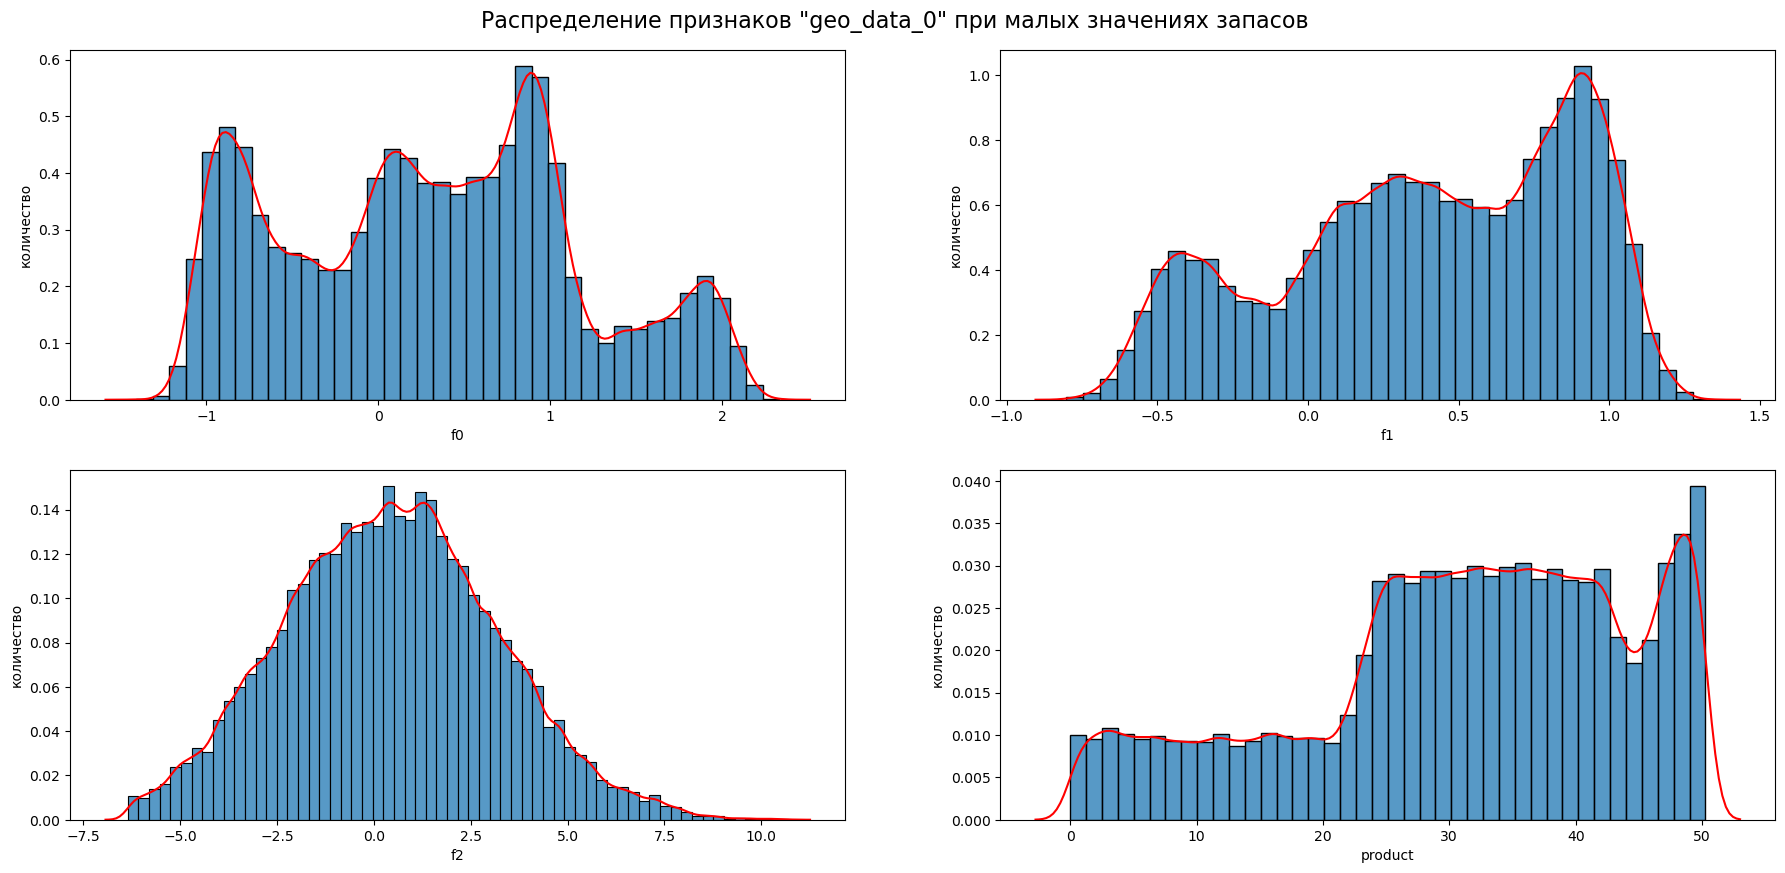

In [21]:
plt_distribution(geo_data_0.query(f'product <= {geo_data_0["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_0" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для первого региона:**
- Влияние на высокие значения:
    1. `f0`: вторая и четвертая вершины имеют наибольшее влияние, а также третья. Смею предположить, что данный синтетический признак является категориальным с добавлением сильного шума для каждой из четырех категорий.
    2. `f1`: первая вершина имеет наибольшее влияние, вторая и третия по уменьшению значимости. Возможно, данный признак тоже является категориальным.
    3. `f2`: значения близкие к 3 квартилю имеют высокие значения запасов.

- Влияние на малые значения:
    1. `f0`: первая, вторая и третья вершины имеют наибольшее влияние на малые значения.
    2. `f1`: обратно пропорционально высокому значению.
    3. `f2`: значения близкие к 1 квартилю имеют малые значения запасов.

Признаки `f0` и `f1` следует перевести в категориальные. 

In [22]:
# функция для нахождения точек минимумов по оси абцисс и перевода признака в категориальный
def get_min_extrema(*cols, df):
    plt.figure(figsize=(22, 10))
    kde_min = {}
    
    for i, clm in enumerate(cols):
        plt.subplot(2, len(cols), i+1)
        #data = df[clm].values
        
        # нахождение минимумов
        kde = st.gaussian_kde(df[clm], bw_method=0.07)
        x = np.linspace(df[clm].quantile(0.005), df[clm].quantile(0.995), 5000) # по 99 доверительному интервалу
        y = kde(x)

        minimum_indices = argrelextrema(y, np.less)[0]
        minimum_x = x[minimum_indices]
        
        # отрисовка количественных с минимумами
        print(f"Точки минимумов KDE({clm}):", minimum_x)
        axes = sns.histplot(data=df, x=clm, stat="density")
        for x in minimum_x:
            plt.axvline(x=x, color='r', linestyle='--', alpha=0.5)
        axes.set_ylabel('количество')
        
        # перевод в категориальный
        kde_min[clm] = [-np.inf] + minimum_x.tolist() + [np.inf]
        df[clm] = pd.cut(
                    x=df[clm],
                    bins=kde_min[clm],
                    labels=[*range(len(kde_min[clm])-1)]
                    )
        
        # отрисовка категориальных
        plt.subplot(2, len(cols), i+1+len(cols))
        axes = sns.countplot(data=df, x=clm)
        axes.set_ylabel('количество')
        
    return df

Точки минимумов KDE(f0): [-0.31291658  0.47001752  1.33850402]
Точки минимумов KDE(f1): [-0.11982462  0.63806697]


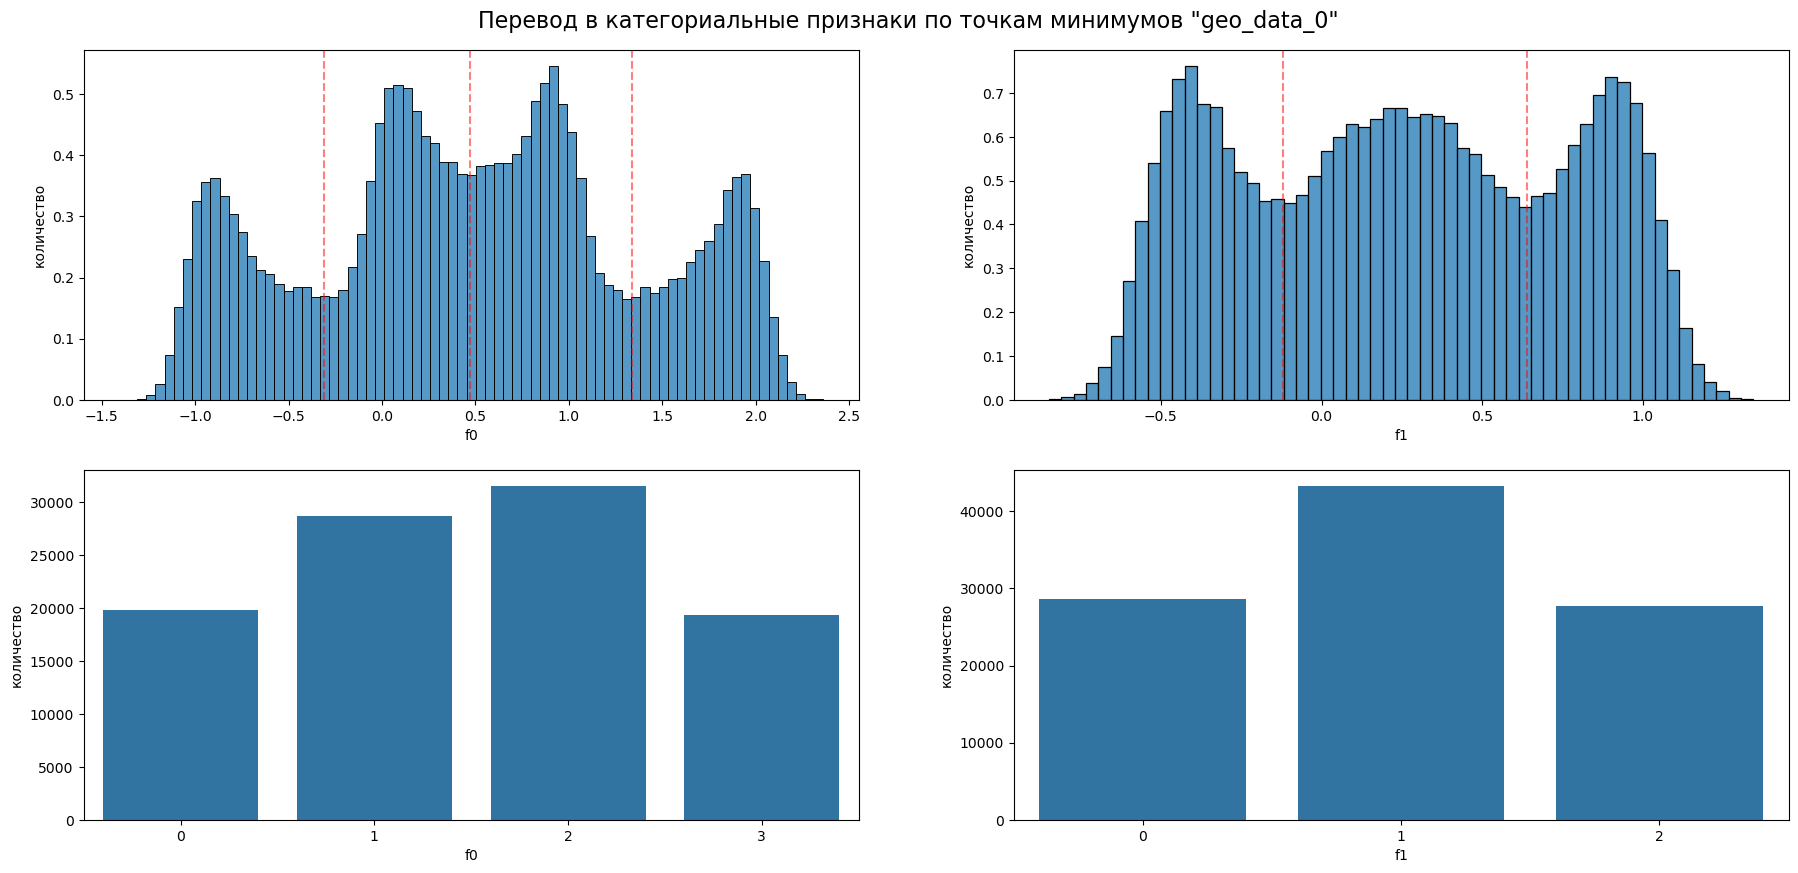

In [ ]:
get_min_extrema('f0', 'f1', df=geo_data_0)
plt.suptitle('Перевод в категориальные признаки по точкам минимумов "geo_data_0"', fontsize=16, y=0.92)
plt.show()

In [36]:
display(geo_data_0.head())
geo_data_0.info()

,id,f0,f1,f2,product
0,txEyH,2,0,1.221170,105.280062
1,2acmU,2,0,4.365080,73.037750
2,409Wp,2,1,1.419926,85.265647
3,iJLyR,1,1,2.978566,168.620776
4,Xdl7t,3,1,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99494 entries, 0 to 99493
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       99494 non-null  object  
 1   f0       99494 non-null  category
 2   f1       99494 non-null  category
 3   f2       99494 non-null  float64 
 4   product  99494 non-null  float64 
dtypes: category(2), float64(2), object(1)
memory usage: 2.5+ MB


Признаки `f0` и `f1` были переведы в категориальные по точкам минимумов экстремумов.

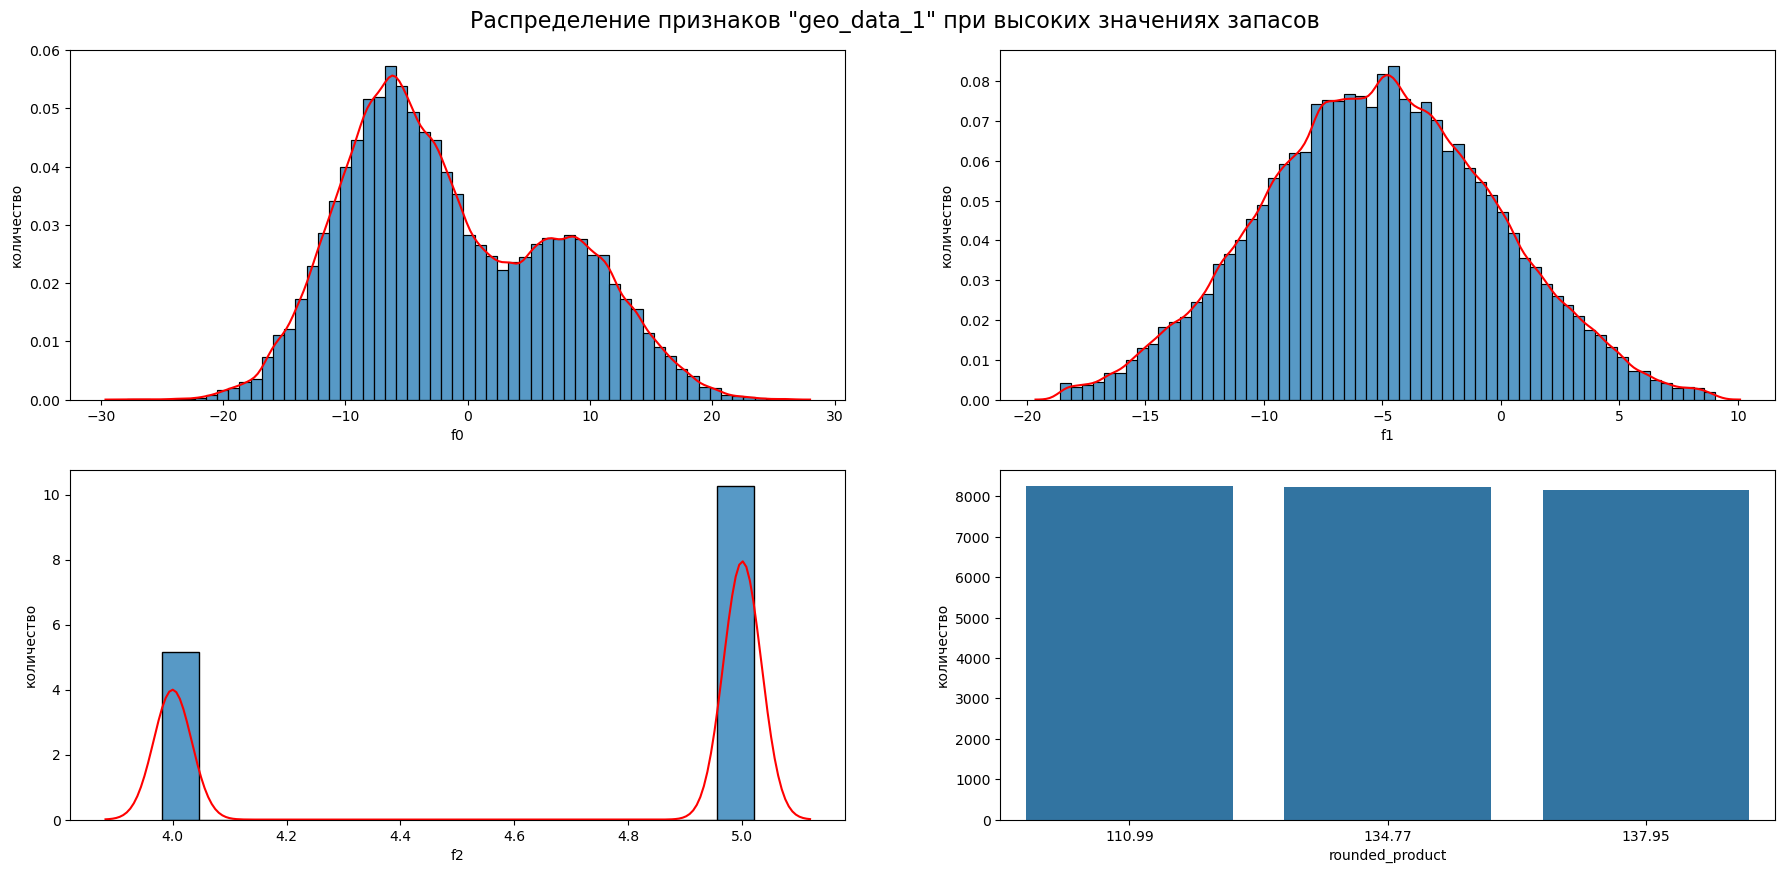

In [24]:
plt_distribution(geo_data_1.query(f'product >= {geo_data_1["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_1" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

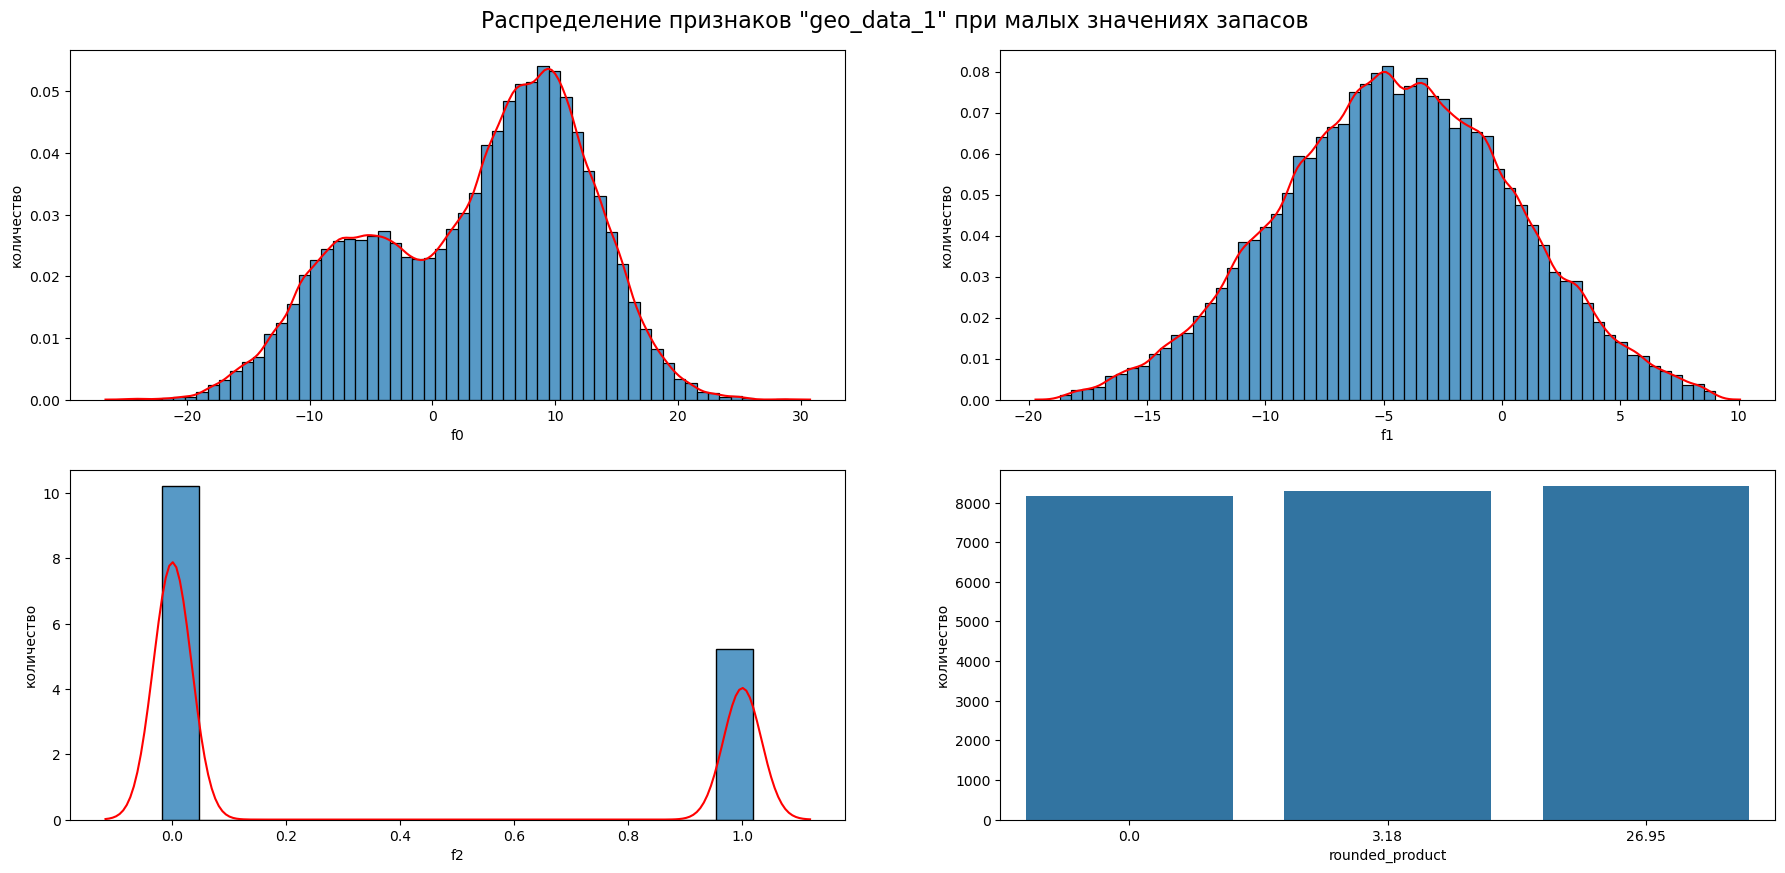

In [25]:
plt_distribution(geo_data_1.query(f'product <= {geo_data_1["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_1" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для второго региона:**
- Влияние на высокие значения:
    1. `f0`: первая вершина имеет наибольшее влияние. Данный признак тоже может быть категориальным.
    2. `f1`: значения данного признака не имеют влияния на большие запасы.
    3. `f2`: значения близкие к 4 и 5 имеют высокие значения запасов.
- Влияние на малые значения:
    1. `f0`: обратно пропорционально высокому значению.
    2. `f1`: значения данного признака не имеют влияния на малые запасы.
    3. `f2`: значения близкие к 0 и 1 имеют малые значения запасов.

Признаки `f0` и `f2` стоит перевести в категориальные. Признак `f1` не имеет никакого влияния на малые и высокие значения запасов топлива в скважине.

Точки минимумов KDE(f0): [0.72011971]
Точки минимумов KDE(f2): [0.49963662 1.49959681 2.50056097 3.50052116 4.50048134]


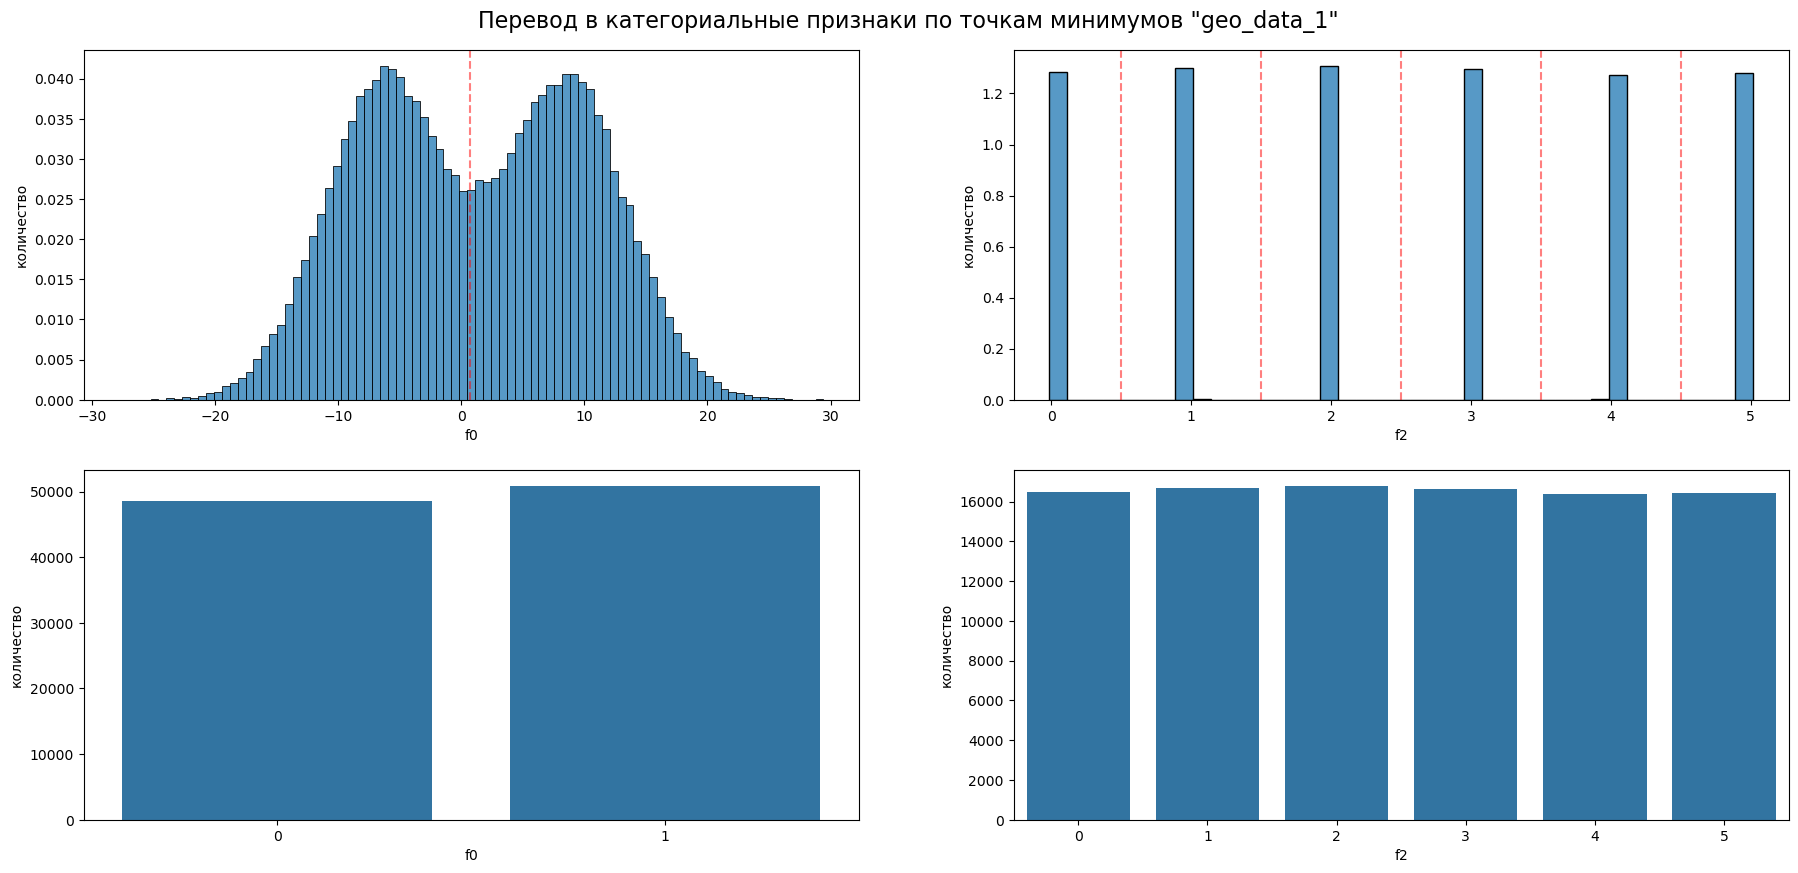

In [27]:
get_min_extrema('f0', 'f2', df=geo_data_1)
plt.suptitle('Перевод в категориальные признаки по точкам минимумов "geo_data_1"', fontsize=16, y=0.92)
plt.show()

In [37]:
display(geo_data_1.head())
geo_data_1.info()

,id,f0,f1,f2,product
0,kBEdx,0,-8.276000,0,3.179103
1,62mP7,1,-3.475083,1,26.953261
2,vyE1P,1,-5.948386,5,134.766305
3,KcrkZ,0,-11.506057,5,137.945408
4,AHL4O,1,-8.147433,5,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99363 entries, 0 to 99362
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       99363 non-null  object  
 1   f0       99363 non-null  category
 2   f1       99363 non-null  float64 
 3   f2       99363 non-null  category
 4   product  99363 non-null  float64 
dtypes: category(2), float64(2), object(1)
memory usage: 2.5+ MB


Признаки `f0` и `f2` были переведы в категориальные по точкам минимумов экстремумов.

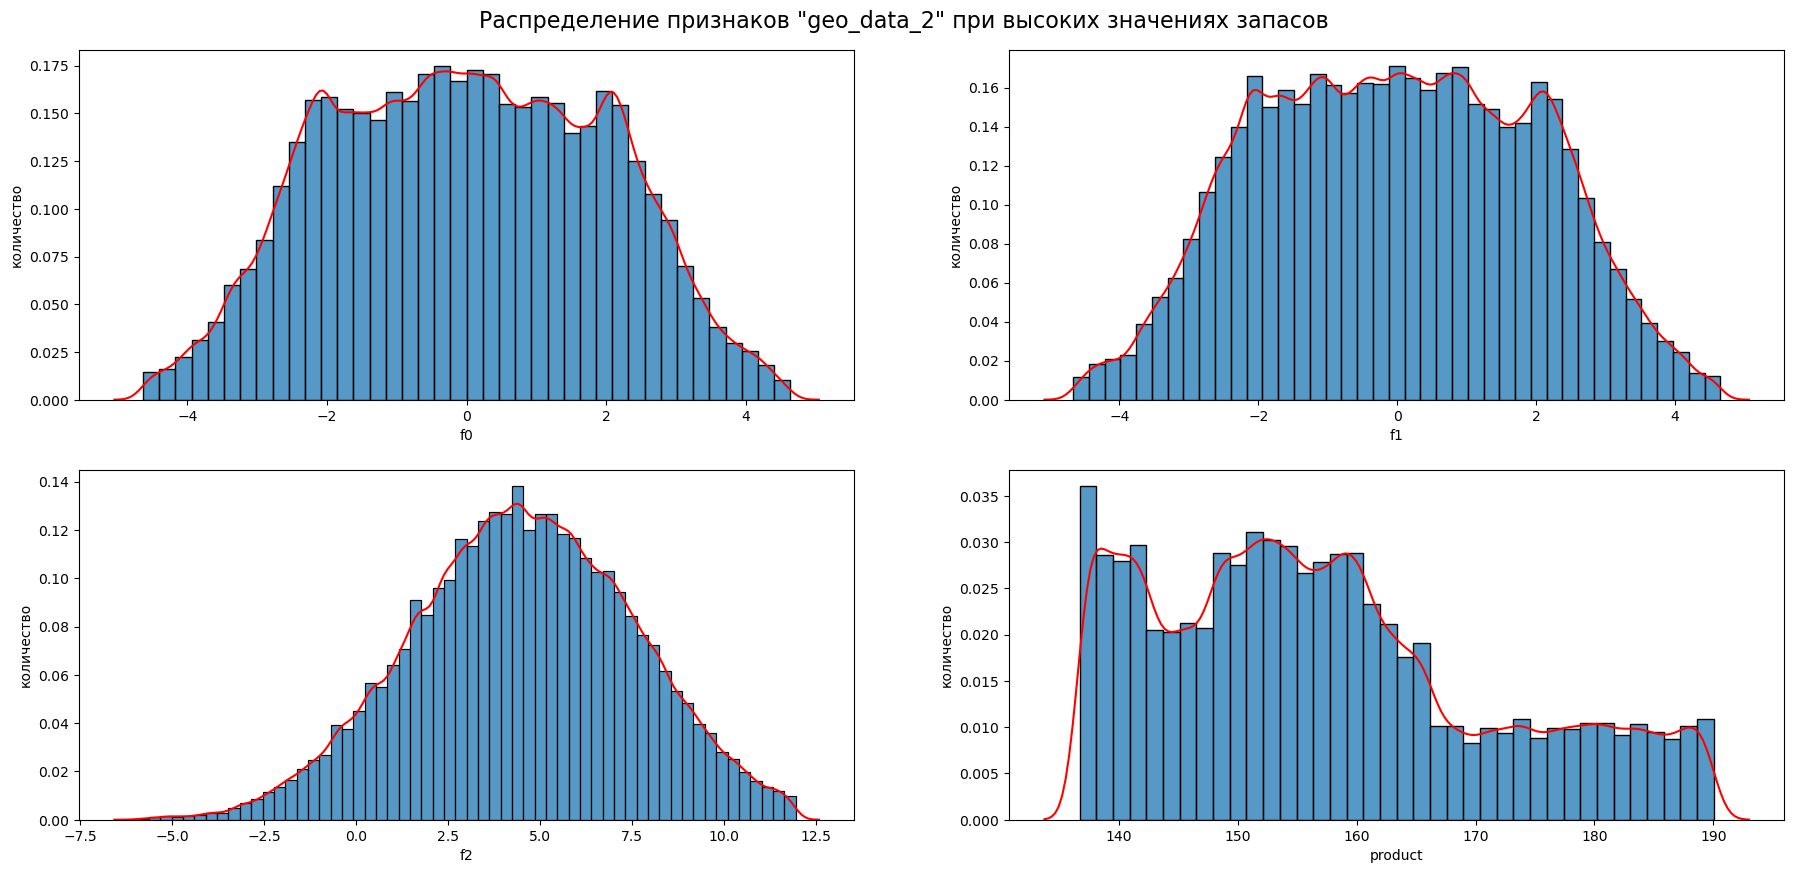

In [29]:
plt_distribution(geo_data_2.query(f'product >= {geo_data_2["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_2" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

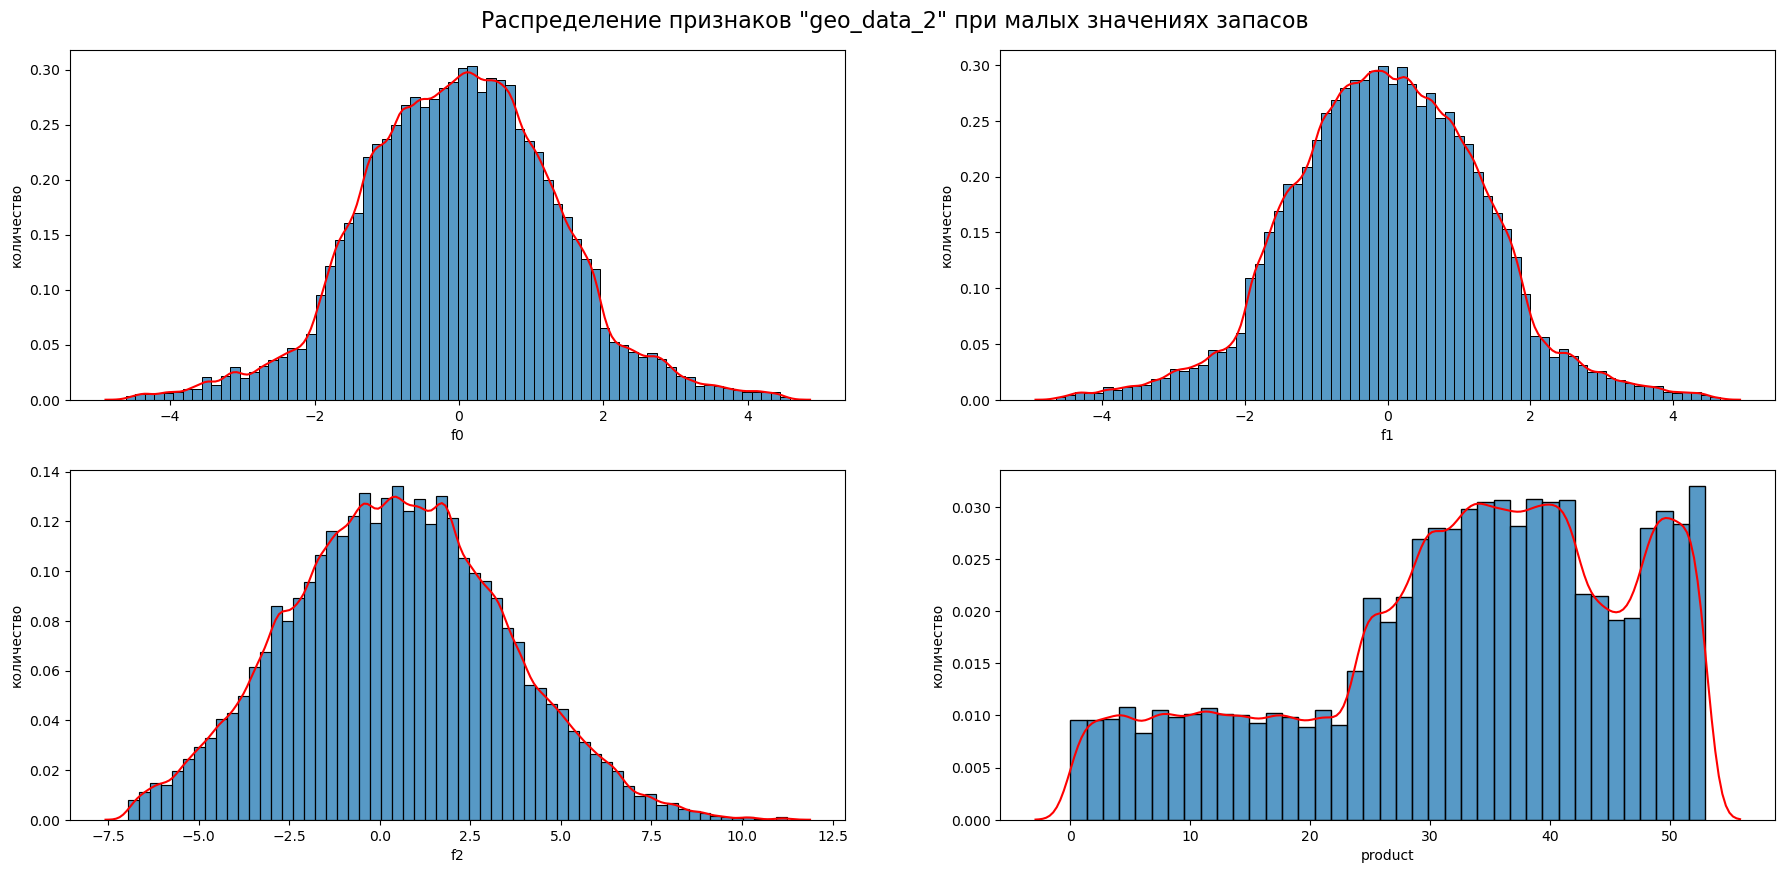

In [30]:
plt_distribution(geo_data_2.query(f'product <= {geo_data_2["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_2" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для третьего региона:**
- Влияние на высокие значения:
    1. `f0`: значения находящиеся в 50% доверительном интервале.
    2. `f1`: значения находящиеся в 50% доверительном интервале.
    3. `f2`: значения близкие к 3 квартилю.
- Влияние на малые значения:
    1. `f0`: значения близкие к 0 (медиане)
    2. `f1`: значения близкие к 0 (медиане)
    3. `f2`: значения близкие к 1 квартилю.

Значения признаков `f0` и `f1` имеют неоднозначное влияние на малые запасы топлива.

#### Корреляционный анализ

In [31]:
def plt_scatter(df):
    plt.figure(figsize=(16, 6))
    cols = [clm for clm in df.select_dtypes(include='number').columns if clm != 'product']
    for i, clm in enumerate(cols):
        plt.subplot(1, 3, i+1)
        sns.scatterplot(data=geo_data_0, y=clm, x='product')

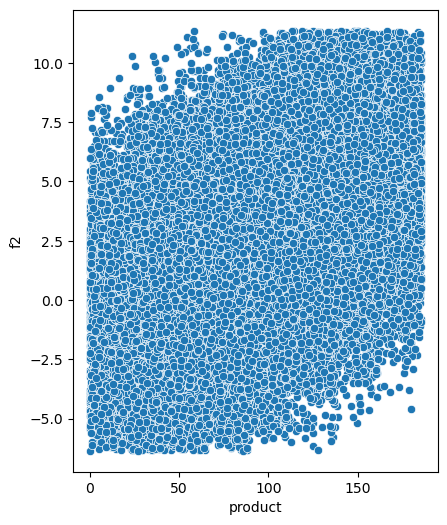

In [32]:
plt_scatter(geo_data_0)